DEMO 8/19:

In [9]:
# Setup for Windows NVIDIA

import sys, platform
print("Kernel interpreter:", sys.executable)
print("Python version   :", platform.python_version())

%pip install -U pip setuptools wheel
#ARIMA/SARIMAX
%pip install -U statsmodels

#  Torch 2.6.0 + CUDA 12.6  (pairs with torchvision 0.21.0)
%pip install torch==2.6.0 torchvision==0.21.0 --index-url https://download.pytorch.org/whl/cu126

# Rest of the stack 
%pip install "pytorch-lightning==2.5.3" "pytorch-forecasting==1.4.0" "neuralforecast==3.0.2" \
             "optuna>=3.5" "pandas>=2.2" "numpy>=1.26" "scikit-learn>=1.4" "matplotlib>=3.8" "seaborn>=0.13"

# --- sanity check (catches wrong kernel / CPU torch) 
import importlib, torch, pytorch_lightning as pl, torch.optim.lr_scheduler as lrs
nf = importlib.import_module("neuralforecast")
pf = importlib.import_module("pytorch_forecasting")

print({
    "torch": torch.__version__,
    "torch_cuda": getattr(torch.version, "cuda", None),
    "cuda_available": torch.cuda.is_available(),
    "gpu": torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
    "has_LRScheduler": hasattr(lrs, "LRScheduler"),
    "lightning": pl.__version__,
    "neuralforecast": nf.__version__,
    "pytorch_forecasting": pf.__version__,
})


Kernel interpreter: c:\Users\Rohan\AppData\Local\Programs\Python\Python310\python.exe
Python version   : 3.10.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
{'torch': '2.6.0+cu126', 'torch_cuda': '12.6', 'cuda_available': True, 'gpu': 'NVIDIA GeForce RTX 4060 Ti', 'has_LRScheduler': True, 'lightning': '2.5.3', 'neuralforecast': '3.0.2', 'pytorch_forecasting': '1.4.0'}


In [10]:
# Imports, config, reproducibility — Torch 2.x / Lightning 2.x / NF 3.x

import os, json, math, time, warnings, random, sys
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# NeuralForecast (Informer)
from neuralforecast import NeuralForecast
from neuralforecast.models import Informer as NFInformer
from neuralforecast.losses.pytorch import MSE

# PyTorch-Forecasting (TFT baseline)
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# Reproducibility & device setup 
warnings.filterwarnings("ignore")
pl.seed_everything(42, workers=True)
torch.set_float32_matmul_precision("high")

DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(exist_ok=True)

@dataclass
class CFG:
    RAW_FILE: str = "pollution_2000_2023.csv" 
    INPUT_WINDOW: int = 60
    PRED_WINDOW: int = 3
    TRAIN_END: str = "2016-12-31"
    VAL_END: str   = "2020-12-31"
    # Informer hyperparams
    HIDDEN_SIZE: int = 128
    N_HEAD: int = 4
    FACTOR: int = 10
    DROPOUT: float = 0.1
    LR: float = 1e-3
    MAX_STEPS: int = 5000
    # Rolling evaluation
    ROLL_STEP_DAYS: int = 7

CFG = CFG()

#catching kernal/env details in the event of mishap
print({
    "python": sys.executable,
    "device": DEVICE,
    "torch": torch.__version__,
    "lightning": pl.__version__,
    "neuralforecast": __import__("neuralforecast").__version__,
    "pytorch_forecasting": __import__("pytorch_forecasting").__version__,
})


Seed set to 42


{'python': 'c:\\Users\\Rohan\\AppData\\Local\\Programs\\Python\\Python310\\python.exe', 'device': 'cuda', 'torch': '2.6.0+cu126', 'lightning': '2.5.3', 'neuralforecast': '3.0.2', 'pytorch_forecasting': '1.4.0'}


In [11]:
#utility functions

import re
from collections import defaultdict
from datetime import datetime, timedelta

# metrics
def rmse(a, b):
    return float(np.sqrt(((np.asarray(a) - np.asarray(b)) ** 2).mean()))

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return float(100.0 * np.mean(np.abs(y_pred - y_true) / denom))

# like units for reporting
# In this Kaggle/EPA daily file: NO2 values are in ppb; O3/CO/SO2 typically in ppm.
PPB_SCALE = {"O3": 1000.0, "CO": 1000.0, "SO2": 1000.0, "NO2": 1.0}

def to_ppb(arr, pollutant):
    s = PPB_SCALE[pollutant]
    return np.asarray(arr) * s

##column name and schema conversion
def load_and_standardize(csv_path: str) -> pd.DataFrame:
    """
    Loads the Kaggle 'U.S. Pollution Data 2000-2023' CSV and normalizes schema:
      - lower_snake_case columns
      - date column -> 'date' (datetime64)
      - pollutants -> columns: 'o3', 'no2', 'so2', 'co'
      - keep 'city', 'state'
    """
    df = pd.read_csv(csv_path, low_memory=False)
    df.columns = (
        pd.Series(df.columns)
        .str.strip()
        .str.lower()
        .str.replace(r"[^a-z0-9]+", "_", regex=True)
        .str.replace(r"_+", "_", regex=True)
        .str.strip("_")
        .to_list()
    )
    # Date
    date_candidates = ["date", "date_local", "date_"]
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        raise ValueError("No date column found. Expected one of: " + ", ".join(date_candidates))
    df["date"] = pd.to_datetime(df[date_col])
    # City/State
    if "city" not in df.columns or "state" not in df.columns:
        raise ValueError("Expected 'city' and 'state' columns.")
    # Pollutants: accept either *_mean or simple names
    name_map = {
        "o3": ["o3_mean", "o3", "ozone"],
        "no2": ["no2_mean", "no2"],
        "so2": ["so2_mean", "so2"],
        "co": ["co_mean", "co"],
    }
    out = pd.DataFrame({
        "date": df["date"],
        "city": df["city"].astype(str),
        "state": df["state"].astype(str),
    })
    for key, cands in name_map.items():
        col = next((c for c in cands if c in df.columns), None)
        if col is None:
            raise ValueError(f"Expected column for {key}: one of {cands}")
        out[key] = pd.to_numeric(df[col], errors="coerce")
    # drop dupes/na and sort
    out = out.dropna(subset=["o3", "no2", "so2", "co"]).sort_values(["city", "state", "date"]).reset_index(drop=True)
    return out

def make_features(df: pd.DataFrame) -> pd.DataFrame:
    """Calendar features + simple lag(1) per pollutant."""
    out = df.copy()
    out["month"] = out["date"].dt.month.astype(int)
    out["dayofweek"] = out["date"].dt.dayofweek.astype(int)
    out["isweekend"] = out["dayofweek"].isin([5, 6]).astype(int)
    out["iswedthur"] = out["dayofweek"].isin([2, 3]).astype(int)

    # lag(1) per pollutant by city/state
    for p in ["o3", "no2", "so2", "co"]:
        out[f"{p}_lag1"] = out.groupby(["city", "state"])[p].shift(1)

    # average pollution for context (same units as native)
    out["pollution_avg"] = out[["o3", "no2", "so2", "co"]].mean(axis=1)
    out = out.dropna().reset_index(drop=True)
    return out

def to_long(df_feat: pd.DataFrame) -> pd.DataFrame:
    """Melt wide -> long: (city,state,date) × pollutant -> y; create unique_id and y_lag1 by series."""
    long = df_feat.melt(
        id_vars=["date", "city", "state", "month", "dayofweek", "isweekend", "iswedthur",
                 "o3_lag1", "no2_lag1", "so2_lag1", "co_lag1", "pollution_avg"],
        value_vars=["o3", "no2", "so2", "co"],
        var_name="pollutant",
        value_name="y",
    )
    long["pollutant"] = long["pollutant"].str.upper()
    long["unique_id"] = (
        long["city"].str.replace(r"[^A-Za-z0-9]+", "", regex=True)
        + "_" +
        long["state"].str.replace(r"[^A-Za-z0-9]+", "", regex=True)
        + "_" +
        long["pollutant"].str.lower()
    ).str.lower()
    long = long.sort_values(["unique_id", "date"]).reset_index(drop=True)
    # create a universal y_lag1 in the long frame (per unique series)
    long["y_lag1"] = long.groupby("unique_id")["y"].shift(1)
    long = long.dropna(subset=["y", "y_lag1"]).reset_index(drop=True)
    return long

def pick_subset_cities(df: pd.DataFrame, top_n=8, min_years=10) -> list:
    """
    Pick a representative subset by city with longest coverage.
    Returns a list of city names (case-sensitive as in data).
    """
    city_counts = (df.groupby(["city"])["date"].count().rename("n").reset_index())
    # bias toward cities with the longest span (min max year diff)
    spans = df.groupby("city")["date"].agg(["min", "max"])
    spans["years"] = (spans["max"] - spans["min"]).dt.days / 365.25
    merged = city_counts.merge(spans.reset_index(), on="city")
    merged = merged[merged["years"] >= min_years].sort_values(["n", "years"], ascending=False)
    chosen = merged["city"].head(top_n).tolist()
    return chosen

def print_split_counts(long_df, train_end, val_end):
    train_mask = long_df["date"] <= train_end
    val_mask   = (long_df["date"] > train_end) & (long_df["date"] <= val_end)
    test_mask  = long_df["date"] > val_end
    print("=== Split row counts ===")
    print({
        "raw_rows": len(long_df),
        "train_rows": int(train_mask.sum()),
        "val_rows": int(val_mask.sum()),
        "test_rows": int(test_mask.sum())
    })
    uniq = lambda m: long_df.loc[m, "unique_id"].nunique()
    print("=== Unique series per split ===")
    print({
        "train_unique_series": uniq(train_mask),
        "val_unique_series": uniq(val_mask),
        "test_unique_series": uniq(test_mask),
    })

def anchors_between(start_ts, end_ts, step_days=14):
    """Yield anchor datetimes from start to end inclusive with given step."""
    cur = pd.Timestamp(start_ts)
    end = pd.Timestamp(end_ts)
    while cur <= end:
        yield cur
        cur += pd.Timedelta(days=step_days)

# For consistent plotting fonts
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


In [12]:
# load raw CSV, add features, choose subset cities, long format

# load & feature engineering ----
df_raw = load_and_standardize(CFG.RAW_FILE)
print(f"Loaded: {CFG.RAW_FILE} | rows={len(df_raw):,}")
print(df_raw.head())

df_feat = make_features(df_raw)
print("Feature columns added. Preview:")
print(df_feat.sample(5).head(10))

# picking a small subset for demo (top N cities by coverage) ----
TOP_N_CITIES = 8 #for this demo choosing 8 cities so it runs at a decent pace
SUBSET_CITIES = pick_subset_cities(df_feat, top_n=TOP_N_CITIES, min_years=10)
print("Chosen subset cities:", SUBSET_CITIES)

df_sub = df_feat[df_feat["city"].isin(SUBSET_CITIES)].copy()

# ---- Long format ----
df_long = to_long(df_sub)
print(f"Long rows: {len(df_long):,} | series={df_long['unique_id'].nunique()}")
print(df_long[["unique_id", "date", "y"]].head())

Loaded: pollution_2000_2023.csv | rows=665,414
        date         city       state        o3        no2       so2        co
0 2011-01-01  Albuquerque  New Mexico  0.032471   9.180952  0.054167  0.200000
1 2011-01-02  Albuquerque  New Mexico  0.018824  11.504762  0.162500  0.275000
2 2011-01-03  Albuquerque  New Mexico  0.008412  23.342857  0.720833  0.479167
3 2011-01-04  Albuquerque  New Mexico  0.027471  23.245455  0.887500  0.604167
4 2011-01-05  Albuquerque  New Mexico  0.033294  12.637500  0.445833  0.204167
Feature columns added. Preview:
             date        city       state        o3        no2       so2  \
29273  2007-02-03  Beltsville    Maryland  0.018824   9.434783  3.037500   
522334 2019-11-19    Rubidoux  California  0.033353  26.479167  0.566667   
372483 2012-05-19      Newark  New Jersey  0.028706  25.583333  2.983333   
527499 2016-06-10     Rutland     Vermont  0.013417   1.873333  0.010000   
571718 2021-12-10     Seattle  Washington  0.022765  10.531818  0.0

In [13]:
# chronological splits + sanity check stats

TRAIN_END = pd.Timestamp(CFG.TRAIN_END)
VAL_END   = pd.Timestamp(CFG.VAL_END)

print_split_counts(df_long, TRAIN_END, VAL_END)

train_mask = df_long["date"] <= TRAIN_END
val_mask  = (df_long["date"] > TRAIN_END) & (df_long["date"] <= VAL_END)
test_mask = df_long["date"] > VAL_END

df_train = df_long[train_mask].copy()
df_val = df_long[val_mask].copy()
df_test = df_long[test_mask].copy()

print("Date ranges:",
      df_train["date"].min().date(), "→", df_train["date"].max().date(), "(train)",
      "|", df_val["date"].min().date() if len(df_val) else None, "→", df_val["date"].max().date() if len(df_val) else None, "(val)",
      "|", df_test["date"].min().date() if len(df_test) else None, "→", df_test["date"].max().date() if len(df_test) else None, "(test)")


=== Split row counts ===
{'raw_rows': 615496, 'train_rows': 421744, 'val_rows': 120672, 'test_rows': 73080}
=== Unique series per split ===
{'train_unique_series': 104, 'val_unique_series': 60, 'test_unique_series': 52}
Date ranges: 2000-01-02 → 2016-12-31 (train) | 2017-01-01 → 2020-12-31 (val) | 2021-01-01 → 2023-09-30 (test)


In [14]:
# shared evaluation helpers (join, per‑pollutant metrics, rolling eval)

def per_pollutant_metrics(truth_df: pd.DataFrame, pred_df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    """
    truth_df: columns ['unique_id','date','pollutant','y']
    pred_df : columns ['unique_id','date','y_pred']
    Returns a per-pollutant DataFrame with R2, MSE(ppb^2), SMAPE(%).
    """
    merged = (truth_df.merge(pred_df, on=["unique_id","date"], how="inner")).copy()
    out_rows = []
    for pol, g in merged.groupby("pollutant"):
        # Harmonize to ppb for error magnitudes
        y_ppb     = to_ppb(g["y"].values, pol)
        yhat_ppb  = to_ppb(g["y_pred"].values, pol)
        out_rows.append({
            "model": model_name,
            "pollutant": pol,
            "R2": float(r2_score(g["y"].values, g["y_pred"].values)),  # unit-invariant
            "MSE_ppb2": float(np.mean((y_ppb - yhat_ppb)**2)),
            "SMAPE_%": smape(y_ppb, yhat_ppb),
            "N": int(len(g))
        })
    return pd.DataFrame(out_rows)

def rolling_eval(
    predict_fn,            # callable(anchor_ts) -> DataFrame with ['unique_id','date','y_pred']
    truth_full: pd.DataFrame,  # full long truth df (we will slice per-anchor)
    start_ts: pd.Timestamp,
    end_ts: pd.Timestamp,
    step_days: int,
    horizon: int,
    model_name: str,
) -> pd.DataFrame:
    """
    Calls predict_fn(anchor) at each rolling anchor and aggregates per-pollutant metrics.
    Returns a table: [anchor, pollutant, R2, MSE_ppb2, SMAPE_%, N]
    """
    rows = []
    for a in anchors_between(start_ts, end_ts - pd.Timedelta(days=horizon-1), step_days=step_days):
        # restrict truth to the H-day window after anchor
        mask = (truth_full["date"] > a) & (truth_full["date"] <= a + pd.Timedelta(days=horizon))
        truth = truth_full.loc[mask, ["unique_id","date","pollutant","y"]].copy()
        preds = predict_fn(a)
        met = per_pollutant_metrics(truth, preds, model_name)
        met.insert(0, "anchor_date", a.date().isoformat())
        rows.append(met)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["anchor_date","model","pollutant","R2","MSE_ppb2","SMAPE_%","N"])


In [15]:
# Informer — train on subset, immediate & rolling evaluation (subset cities)

# Build NeuralForecast long format: ['unique_id','ds','y']
df_nf = df_long.rename(columns={"date":"ds"})[["unique_id","ds","y"]].copy()

# Train/val cut
df_train_val_nf = df_nf[df_nf["ds"] <= VAL_END].copy()

INF_H = CFG.PRED_WINDOW
INF_L = CFG.INPUT_WINDOW
INF_HIDDEN = 64   
INF_FACTOR = 10
INF_HEADS = 4
INF_MAX_STEPS = 1000   #lowered for demo
INF_LR = CFG.LR

nf_informer = NFInformer(
    h=INF_H,
    input_size=INF_L,
    hidden_size=INF_HIDDEN,
    n_head=INF_HEADS,
    factor=INF_FACTOR,
    dropout=CFG.DROPOUT,
    learning_rate=INF_LR,
    loss=MSE(),
    scaler_type="standard",
    max_steps=INF_MAX_STEPS,
    val_check_steps=100,   # evaluate every N steps
)

nf = NeuralForecast(models=[nf_informer], freq="D")
print("Training Informer on subset cities …")
t0 = time.perf_counter()
nf.fit(df=df_train_val_nf)
t_train = time.perf_counter() - t0
print(f"Informer trained in {t_train:.2f} s")

# ---------- Immediate-horizon eval (first test window) ----------
first_anchor = pd.Timestamp(VAL_END)  # anchor at 2020-12-31, predict 2021-01-01..03
def informer_predict_at(anchor_ts: pd.Timestamp) -> pd.DataFrame:
    # Pass observed until anchor to forecast next H days (H fixed in model init)
    df_cut = df_nf[df_nf["ds"] <= anchor_ts].copy()

    preds = nf.predict(df=df_cut)  # wide df: ['unique_id','ds','<model-name>']
    pred_col = [c for c in preds.columns if c not in ("unique_id", "ds")][0]

    # Standardize to our evaluation schema
    preds = preds.rename(columns={pred_col: "y_pred", "ds": "date"})
    preds["date"] = pd.to_datetime(preds["date"])

    return preds[["unique_id", "date", "y_pred"]]

print("Informer: predicting first horizon …")
t0 = time.perf_counter()
preds_first = informer_predict_at(first_anchor)
t_pred = time.perf_counter() - t0

# Prepare truth for first horizon
mask = (df_long["date"] > first_anchor) & (df_long["date"] <= first_anchor + pd.Timedelta(days=INF_H))
truth_first = df_long.loc[mask, ["unique_id","date","pollutant","y"]].copy()

inf_first_tbl = per_pollutant_metrics(truth_first, preds_first, "Informer")
print("Informer — immediate horizon metrics (subset, ppb units for errors)")
display(inf_first_tbl)

roll_start = df_test["date"].min()
roll_end   = df_test["date"].max()
STEP = CFG.ROLL_STEP_DAYS 

print(f"Informer rolling eval from {roll_start.date()} to {roll_end.date()} every {STEP} days …")
t0 = time.perf_counter()
inf_roll_tbl = rolling_eval(informer_predict_at, df_long, roll_start, roll_end, STEP, INF_H, "Informer")
t_roll = time.perf_counter() - t0
print(f"Rolling eval done in {t_roll:.2f} s")
display(inf_roll_tbl.groupby(["pollutant"]).agg({"R2":"mean","MSE_ppb2":"mean","SMAPE_%":"mean","N":"sum"}).round(3))


Seed set to 1


Training Informer on subset cities …


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 192    | train
4 | dec_embedding | DataEmbedding | 192    | train
5 | encoder       | TransEncoder  | 54.8 K | train
6 | decoder       | TransDecoder  | 38.0 K | train
--------------------------------------------------------
93.2 K    Trainable params
0         Non-trainable params
93.2 K    Total params
0.373     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 249: 100%|██████████| 4/4 [00:00<00:00,  8.79it/s, v_num=615, train_loss_step=0.942, train_loss_epoch=0.984]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 249: 100%|██████████| 4/4 [00:00<00:00,  8.69it/s, v_num=615, train_loss_step=0.942, train_loss_epoch=0.984]
Informer trained in 99.40 s
Informer: predicting first horizon …


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 45.45it/s]
Informer — immediate horizon metrics (subset, ppb units for errors)


,model,pollutant,R2,MSE_ppb2,SMAPE_%,N
0,Informer,CO,0.598111,15576.516867,12.844706,66
1,Informer,NO2,0.664154,17.494324,19.423934,66
2,Informer,O3,0.014894,37.393420,11.747590,66
3,Informer,SO2,0.713647,45072.394529,28.943695,66


Informer rolling eval from 2021-01-01 to 2023-09-30 every 7 days …


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 54.18it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.92it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 56.85it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 45.99it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.51it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 43.02it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.56it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.54it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 46.23it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.53it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.69it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.15it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.12it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.66it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.64it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.31it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 42.86it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.41it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.61it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.48it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 41.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.46it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.44it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.05it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.39it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 54.83it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.95it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.95it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 57.28it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 57.68it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 46.45it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.42it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.25it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.87it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.32it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.58it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.00it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 54.32it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.58it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 57.03it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.85it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 39.27it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.42it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.57it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 45.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.48it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 54.91it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 42.79it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.95it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.23it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 56.08it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 42.60it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.98it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.78it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.13it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.77it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.40it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.42it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 45.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 46.69it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.51it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 46.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 45.07it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.81it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 39.77it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 54.22it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.09it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 57.47it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.00it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.05it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 46.81it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 46.58it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.52it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.35it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.07it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.98it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 40.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.21it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.53it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.67it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.70it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.01it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.73it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 42.35it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 43.05it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.74it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 43.08it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 46.78it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.77it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.22it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.06it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 39.03it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.09it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.86it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.55it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.93it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 43.15it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 38.55it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.43it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.58it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.12it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.06it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 45.61it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.29it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 50.37it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.11it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.63it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.50it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.73it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.76it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.18it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.80it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.20it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 58.07it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.74it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 56.75it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.68it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 55.19it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.69it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.49it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.60it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 47.47it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 42.23it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.88it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.47it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 42.58it/s]
Rolling eval done in 69.31 s


,R2,MSE_ppb2,SMAPE_%,N
pollutant,,,,
CO,0.191,13866.335,16.398,7755
NO2,-0.060,27.651,19.302,7755
O3,-0.019,57.766,10.501,7755
SO2,0.474,43426.649,32.140,7755


,model,pollutant,R2,MSE_ppb2,SMAPE_%,N
0,Informer,CO,0.598,15576.517,12.845,66
1,Informer,NO2,0.664,17.494,19.424,66
2,Informer,O3,0.015,37.393,11.748,66
3,Informer,SO2,0.714,45072.395,28.944,66


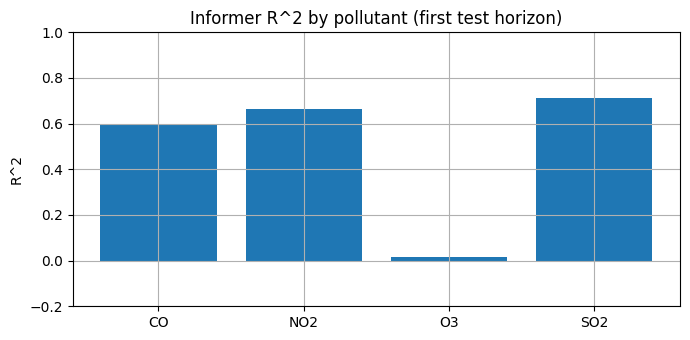

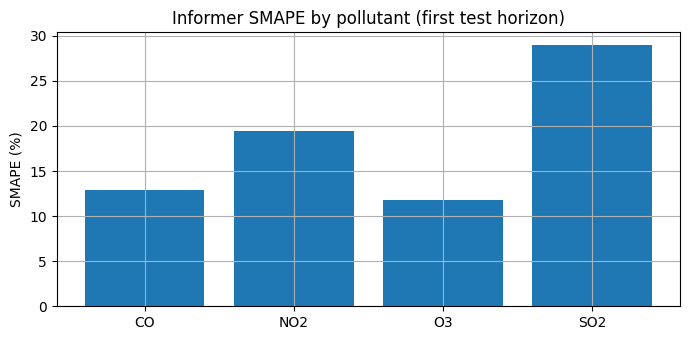

In [17]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Harmonize units for reporting 
PPB_SCALE = {"O3": 1000.0, "CO": 1000.0, "SO2": 1000.0, "NO2": 1.0}

def _norm_cols(df, date_col="date"):
    df = df.copy()
    if "ds" in df.columns and date_col not in df.columns:
        df = df.rename(columns={"ds": date_col})
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
    return df

def per_pollutant_metrics(truth_df: pd.DataFrame, pred_df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    from sklearn.metrics import r2_score
    truth_df = _norm_cols(truth_df, "date")
    pred_df  = _norm_cols(pred_df, "date")
    merged = truth_df.merge(pred_df, on=["unique_id","date"], how="inner")
    out = []
    for pol, g in merged.groupby("pollutant"):
        y   = g["y"].values
        yhat  = g["y_pred"].values
        y_ppb = y    * PPB_SCALE[pol]
        yhat_p = yhat * PPB_SCALE[pol]
        mse_ppb2 = float(np.mean((y_ppb - yhat_p)**2))
        smape  = float(100*np.mean(np.abs(yhat_p - y_ppb)/(np.abs(yhat_p)+np.abs(y_ppb)+1e-8)))
        r2    = float(r2_score(y, yhat)) 
        out.append({"model": model_name, "pollutant": pol, "R2": r2, "MSE_ppb2": mse_ppb2, "SMAPE_%": smape, "N": len(g)})
    return pd.DataFrame(out)

# Normalize input frames and compute metrics
preds_first = _norm_cols(preds_first, "date").rename(columns=lambda c: c)
truth_first = _norm_cols(truth_first, "date").rename(columns=lambda c: c)

inf_first_tbl = per_pollutant_metrics(truth_first, preds_first[["unique_id","date","y_pred"]], "Informer")
display(inf_first_tbl.round(3))

# Bar chart of R^2 by pollutant
plt.figure(figsize=(7,3.5))
plt.bar(inf_first_tbl["pollutant"], inf_first_tbl["R2"])
plt.title("Informer R^2 by pollutant (first test horizon)")
plt.ylim(-0.2, 1.0)
plt.ylabel("R^2")
plt.tight_layout()
plt.show()

# Bar chart of SMAPE by pollutant
plt.figure(figsize=(7,3.5))
plt.bar(inf_first_tbl["pollutant"], inf_first_tbl["SMAPE_%"])
plt.title("Informer SMAPE by pollutant (first test horizon)")
plt.ylabel("SMAPE (%)")
plt.tight_layout()
plt.show()
